# imports

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# TensorFlow ≥2.0 is required
try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
except Exception:
    pass

import tensorflow as tf
assert tf.__version__ >= "2.0"

import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input

# Common imports
import numpy as np
import os
import pandas as pd
import seaborn
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
import math
from pandas.tseries.holiday import USFederalHolidayCalendar
from pandas.tseries.offsets import CustomBusinessDay
from dateutil.relativedelta import relativedelta
from dateutil.parser import parse

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# ignore convergence warning for now
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning,
                            module="sklearn")

2024-05-01 17:59:53.342728: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# data importation

In [2]:
closures = pd.read_csv("Des Moines Closures.csv")
weather_1 = pd.read_csv("Des Moines primary.csv")
hourly = pd.read_csv("DM Hourly Data.csv")

print(closures.info(), weather_1.info(), hourly.info())
#94 expected closures
#18627 weather data points

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 94 entries, 0 to 93
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   DATE          94 non-null     object
 1   Closure Type  94 non-null     object
dtypes: object(2)
memory usage: 1.6+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18627 entries, 0 to 18626
Data columns (total 58 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   STATION          18627 non-null  object 
 1   NAME             18627 non-null  object 
 2   LATITUDE         18627 non-null  float64
 3   LONGITUDE        18627 non-null  float64
 4   ELEVATION        18627 non-null  float64
 5   DATE             18627 non-null  object 
 6   PRCP             18626 non-null  float64
 7   PRCP_ATTRIBUTES  18626 non-null  object 
 8   SNOW             18627 non-null  float64
 9   SNOW_ATTRIBUTES  18627 non-null  object 
 10  SNWD             18627 n

/var/folders/fh/dvn_79bs6b58szfg1vfz4g740000gn/T/ipykernel_5029/1376266264.py:2: DtypeWarning: Columns (17,39,41,43,45,47,49,51,53,55,57) have mixed types. Specify dtype option on import or set low_memory=False.
  weather_1 = pd.read_csv("Des Moines primary.csv")


# data pre-processing - date/time

In [3]:
weather_1['DATE'] = pd.to_datetime(weather_1['DATE'], yearfirst = True, format= '%Y-%m-%d')
closures['DATE'] = pd.to_datetime(closures['DATE'], dayfirst = True, format = '%m/%d/%y')
hourly['DATE'] = pd.to_datetime(hourly['DATE'], format = '%Y%m%d %H:%M')

print(weather_1['DATE'].value_counts(), closures['DATE'].value_counts(), hourly['DATE'].value_counts())

DATE
1973-01-01    1
2007-01-25    1
2007-01-05    1
2007-01-04    1
2007-01-03    1
             ..
1989-12-31    1
1989-12-30    1
1989-12-29    1
1989-12-28    1
2023-12-31    1
Name: count, Length: 18627, dtype: int64 DATE
1973-04-09    1
2010-01-08    1
2013-12-20    1
2013-02-21    1
2013-01-30    1
             ..
1996-01-29    1
1996-01-26    1
1996-01-19    1
1995-12-08    1
2023-01-10    1
Name: count, Length: 94, dtype: int64 DATE
1973-01-01 01:00:00    1
2005-02-13 11:00:00    1
2005-02-13 09:00:00    1
2005-02-13 08:00:00    1
2005-02-13 07:00:00    1
                      ..
1993-01-12 12:00:00    1
1993-01-12 11:00:00    1
1993-01-12 10:00:00    1
1993-01-12 08:00:00    1
2013-12-31 16:00:00    1
Name: count, Length: 33326, dtype: int64


In [4]:
import datetime
def fix_date(x):

    if x.year > 2024:

        year = x.year - 100

    else:

        year = x.year

    return datetime.date(year,x.month,x.day)

weather_1['DATE']=weather_1['DATE'].apply(fix_date)
weather_1['DATE']=pd.to_datetime(weather_1['DATE'], format='%Y-%m-%d')

closures['DATE'] = closures['DATE'].apply(fix_date)
closures['DATE'] = pd.to_datetime(closures['DATE'], format = '%m/%d/%y')

print (closures.info(), closures.head())
print(weather_1.info(), weather_1.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 94 entries, 0 to 93
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   DATE          94 non-null     datetime64[ns]
 1   Closure Type  94 non-null     object        
dtypes: datetime64[ns](1), object(1)
memory usage: 1.6+ KB
None         DATE Closure Type
0 1973-04-09       closed
1 1973-04-10       closed
2 1973-04-11       closed
3 1978-01-05       closed
4 1980-12-08       closed
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18627 entries, 0 to 18626
Data columns (total 58 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   STATION          18627 non-null  object        
 1   NAME             18627 non-null  object        
 2   LATITUDE         18627 non-null  float64       
 3   LONGITUDE        18627 non-null  float64       
 4   ELEVATION        18627 non-null  float64      

# data join 

In [5]:
weather = pd.concat([weather_1])
og = pd.merge(closures, weather, how='right', on='DATE')
print(og.head(), og.info(), og['DATE'].value_counts(), og['NAME'].value_counts(), og['Closure Type'].value_counts())
#18267 weather points #94 closures

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18627 entries, 0 to 18626
Data columns (total 59 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   DATE             18627 non-null  datetime64[ns]
 1   Closure Type     94 non-null     object        
 2   STATION          18627 non-null  object        
 3   NAME             18627 non-null  object        
 4   LATITUDE         18627 non-null  float64       
 5   LONGITUDE        18627 non-null  float64       
 6   ELEVATION        18627 non-null  float64       
 7   PRCP             18626 non-null  float64       
 8   PRCP_ATTRIBUTES  18626 non-null  object        
 9   SNOW             18627 non-null  float64       
 10  SNOW_ATTRIBUTES  18627 non-null  object        
 11  SNWD             18627 non-null  float64       
 12  SNWD_ATTRIBUTES  18627 non-null  object        
 13  TMAX             18626 non-null  float64       
 14  TMAX_ATTRIBUTES  18626 non-null  objec

In [6]:
date_range=pd.date_range('1961-01-01', '2021-12-31')
missing_dates=date_range[~date_range.isin(og['DATE'])]
winter_missing_dates = missing_dates[missing_dates.month.isin([10,11,12,1,2,3,4,5])]
print(missing_dates, winter_missing_dates)
#4383 missing dates
#2919 missing winter weather days

DatetimeIndex(['1961-01-01', '1961-01-02', '1961-01-03', '1961-01-04',
               '1961-01-05', '1961-01-06', '1961-01-07', '1961-01-08',
               '1961-01-09', '1961-01-10',
               ...
               '1972-12-22', '1972-12-23', '1972-12-24', '1972-12-25',
               '1972-12-26', '1972-12-27', '1972-12-28', '1972-12-29',
               '1972-12-30', '1972-12-31'],
              dtype='datetime64[ns]', length=4383, freq='D') DatetimeIndex(['1961-01-01', '1961-01-02', '1961-01-03', '1961-01-04',
               '1961-01-05', '1961-01-06', '1961-01-07', '1961-01-08',
               '1961-01-09', '1961-01-10',
               ...
               '1972-12-22', '1972-12-23', '1972-12-24', '1972-12-25',
               '1972-12-26', '1972-12-27', '1972-12-28', '1972-12-29',
               '1972-12-30', '1972-12-31'],
              dtype='datetime64[ns]', length=2919, freq=None)


# variables drops/additions/renames/filling null values

In [7]:
#remove unnecessary categories like all attribute data, time of observation, elevation, long/lat, and values that not all weather data had
dropped = og.drop(columns=['STATION', 'LATITUDE', 'LONGITUDE', 'ELEVATION', 'PRCP_ATTRIBUTES', 'TMAX_ATTRIBUTES', 'TMIN_ATTRIBUTES', 'SNOW_ATTRIBUTES','SNWD_ATTRIBUTES', 'WT01_ATTRIBUTES', 'WT02_ATTRIBUTES', 'WESD_ATTRIBUTES', 'WT03_ATTRIBUTES', 'WT04_ATTRIBUTES', 'WT05_ATTRIBUTES', 'WT06_ATTRIBUTES', 'WT07_ATTRIBUTES', 'WT08_ATTRIBUTES', 'WT09_ATTRIBUTES', 'WT15_ATTRIBUTES', 'WT16_ATTRIBUTES', 'WT17_ATTRIBUTES', 'WT18_ATTRIBUTES', 'WT11_ATTRIBUTES', 'WT14_ATTRIBUTES', 'WT07', 'WT08', 'WT17',  'WT02', 'WT09', 'WT14', 'WT15', 'WT16', 'WT18', 'WT21_ATTRIBUTES', 'WT22_ATTRIBUTES', 'WT10_ATTRIBUTES', 'WT13_ATTRIBUTES', 'WT19_ATTRIBUTES', 'WT19', 'WT21', 'WT10'])

#rename
dropped.rename(columns={ 'PRCP': 'PrecipitationTotal', 'SNOW':'SnowfallTotal', 'SNWD': 'SnowDepth', 'TMAX':'MaxTemp', 'TMIN':'MinTemp', 'WESD':'WaterEqGroundSnow', 'WT01':'Fog/IceFog/FreezingFog', 'WT03': 'Thunder', 'WT04': 'Ice/Sleet', 'WT05':'Hail', 'WT06':'Glaze','WT11': 'HighWinds','WESF':'WaterEqSnowfall', 'NAME':'Station', 'WT13':'Mist', 'WT22': 'IceFog'}, inplace=True)

In [8]:
dropped.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18627 entries, 0 to 18626
Data columns (total 17 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   DATE                    18627 non-null  datetime64[ns]
 1   Closure Type            94 non-null     object        
 2   Station                 18627 non-null  object        
 3   PrecipitationTotal      18626 non-null  float64       
 4   SnowfallTotal           18627 non-null  float64       
 5   SnowDepth               18627 non-null  float64       
 6   MaxTemp                 18626 non-null  float64       
 7   MinTemp                 18626 non-null  float64       
 8   WaterEqGroundSnow       6703 non-null   float64       
 9   Fog/IceFog/FreezingFog  6879 non-null   float64       
 10  Thunder                 2330 non-null   float64       
 11  Ice/Sleet               303 non-null    float64       
 12  Hail                    455 non-null    float6

In [9]:
#add day, month, year, and day of the week variables
add=dropped.sort_values(by='DATE')
add['Day']=dropped['DATE'].dt.day
add['Day of the Week']=add['DATE'].dt.day_name()
add['Month']=add['DATE'].dt.month
add['Year']=add['DATE'].dt.year

In [10]:
#add dummy variable for early dismissal the day before
add=add.sort_values(by='DATE')
target = 'early dismissal'
add['Previous Early Dismissal'] = add['Closure Type'].apply(lambda x: 1 if x==target else 0)
add['Previous Early Dismissal'] =add['Previous Early Dismissal'].shift(1)
add['Previous Early Dismissal'].fillna(0, inplace=True)

#add school year variable
add=add.sort_values(by='DATE')
add['School Year'] = add['DATE'].dt.year-(add['DATE'].dt.month<7)
add['School Year'] = add['School Year'].astype(int)

#add a shift in closures (to eventually create a cumsum of school days in the year)
add=add.sort_values(by='DATE')
add['Closure_shift']=add['Closure Type'].shift(+1).fillna(0)

In [11]:
#add mapping categorical variables
closure_mapping = {'delayed': 1,
                  'early dismissal': 1,
                  'closed': 1,
                  'virtual snow day' : 1}

closureshift_mapping = {'delayed': 1,
                  'early dismissal': 1,
                  'closed': 1,
                    'virtual snow day' : 1, 
                       '0':0}

weekday_mapping = {'Monday': 0, 
                  'Tuesday' : 1, 
                  'Wednesday': 2, 
                  'Thursday':3, 
                  'Friday': 4,
                  'Saturday': 5, 
                  'Sunday':6}

add['Closure Type']=add['Closure Type'].map(closure_mapping)
add['Day of the Week']=add['Day of the Week'].map(weekday_mapping)
add['Closure_shift']=add['Closure_shift'].map(closureshift_mapping)

#add total school days in the year
grouped=add.groupby('School Year')
add['Snow Days This Year']=grouped['Closure_shift'].cumsum()

In [12]:
#change all numerical data types of int64
add['WaterEqGroundSnow']=add['WaterEqGroundSnow'].astype('float64')
add['SnowfallTotal']=add['SnowfallTotal'].astype('float64')
add['SnowDepth']=add['SnowDepth'].astype('float64')
add['PrecipitationTotal']=add['PrecipitationTotal'].astype('float64')

#fill null values strategically
add['MaxTemp']=add["MaxTemp"].interpolate()
add['MinTemp']=add["MinTemp"].interpolate()

#fill the rest of the null values
add=add.fillna(0)

add['Snow Days This Year'].value_counts()

Snow Days This Year
0.0    18533
1.0       34
2.0       24
3.0       18
4.0        9
5.0        6
6.0        2
7.0        1
Name: count, dtype: int64

In [13]:
#add previous day's weather data
wprevious=add.sort_values(by='DATE')
wprevious['Previous_MinTemp']=wprevious['MinTemp'].shift(1)
wprevious['Previous_MaxTemp']=wprevious['MaxTemp'].shift(1)
wprevious['Previous_SnowfallTotal']=wprevious['SnowfallTotal'].shift(1)
wprevious['Previous_SnowDepth']=wprevious['SnowDepth'].shift(1)
wprevious.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18627 entries, 0 to 18626
Data columns (total 29 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   DATE                      18627 non-null  datetime64[ns]
 1   Closure Type              18627 non-null  float64       
 2   Station                   18627 non-null  object        
 3   PrecipitationTotal        18627 non-null  float64       
 4   SnowfallTotal             18627 non-null  float64       
 5   SnowDepth                 18627 non-null  float64       
 6   MaxTemp                   18627 non-null  float64       
 7   MinTemp                   18627 non-null  float64       
 8   WaterEqGroundSnow         18627 non-null  float64       
 9   Fog/IceFog/FreezingFog    18627 non-null  float64       
 10  Thunder                   18627 non-null  float64       
 11  Ice/Sleet                 18627 non-null  float64       
 12  Hail              

In [14]:
#add vectorlike data over 3 day period
vector=wprevious.sort_values(by='DATE')
vector['MinTempChange']=vector['MinTemp'].diff()
vector['MaxTempChange']=vector['MaxTemp'].diff()
vector['SnowfallTotalChange']=vector['SnowfallTotal'].diff()
vector['SnowDepthChange']=vector['SnowDepth'].diff()
vector['3DayVector_MinTemp']=vector['MinTempChange'].rolling(window=3, min_periods=1).mean()
vector['3DayVector_MaxTemp']=vector['MaxTempChange'].rolling(window=3, min_periods=1).mean()
vector['3DayVector_SnowfallTotal']=vector['SnowfallTotalChange'].rolling(window=3, min_periods=1).mean()
vector['3DayVector_SnowDepth']=vector['SnowDepthChange'].rolling(window=3, min_periods=1).mean()
vector=vector.fillna(0)

vector.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18627 entries, 0 to 18626
Data columns (total 37 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   DATE                      18627 non-null  datetime64[ns]
 1   Closure Type              18627 non-null  float64       
 2   Station                   18627 non-null  object        
 3   PrecipitationTotal        18627 non-null  float64       
 4   SnowfallTotal             18627 non-null  float64       
 5   SnowDepth                 18627 non-null  float64       
 6   MaxTemp                   18627 non-null  float64       
 7   MinTemp                   18627 non-null  float64       
 8   WaterEqGroundSnow         18627 non-null  float64       
 9   Fog/IceFog/FreezingFog    18627 non-null  float64       
 10  Thunder                   18627 non-null  float64       
 11  Ice/Sleet                 18627 non-null  float64       
 12  Hail              

# get rid of common breaks from school

In [15]:
#get rid of summer data
school = vector[~vector.DATE.dt.month.isin([6, 7, 8, 9])]

#get rid of winter break
school = school[~((school['Month']==12) & (school['Day']>22))]
school=school[~((school['Month']==1) & (school['Day']<3))]

#get rid of weekends
school=school[school['DATE'].dt.weekday<5]

#get rid of federal holidays
cal = USFederalHolidayCalendar()
holidays = cal.holidays(start=school['DATE'].min(), end=school['DATE'].max())
school=school[~school['DATE'].isin(holidays)]

#get rid of fri of thanksgiving
bday = CustomBusinessDay(weekmask='Mon Tue Wed Thu Fri')
def get_thanksgiving_dates(year):
    # Find the fourth Thursday of November
    thanksgiving_date = pd.Timestamp(year, 11, 1) + relativedelta(weekday=4, weeks=3)
    # Get the dates for the day before and after Thanksgiving
    pre_thanksgiving = thanksgiving_date - pd.Timedelta(days=1)
    post_thanksgiving = thanksgiving_date + pd.Timedelta(days=1)
    return [pre_thanksgiving, thanksgiving_date, post_thanksgiving]
thanksgiving_dates = []
for year in range(1961,2021):
    thanksgiving_dates.extend(get_thanksgiving_dates(year))
thanksgiving_dates = [parse(date.strftime('%Y-%m-%d')) for date in thanksgiving_dates]
school=school[~school['DATE'].isin(thanksgiving_dates)]


print(school.info(),school['Closure Type'].value_counts())
#93 rather than 94 expected

<class 'pandas.core.frame.DataFrame'>
Index: 8113 entries, 2 to 18617
Data columns (total 37 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   DATE                      8113 non-null   datetime64[ns]
 1   Closure Type              8113 non-null   float64       
 2   Station                   8113 non-null   object        
 3   PrecipitationTotal        8113 non-null   float64       
 4   SnowfallTotal             8113 non-null   float64       
 5   SnowDepth                 8113 non-null   float64       
 6   MaxTemp                   8113 non-null   float64       
 7   MinTemp                   8113 non-null   float64       
 8   WaterEqGroundSnow         8113 non-null   float64       
 9   Fog/IceFog/FreezingFog    8113 non-null   float64       
 10  Thunder                   8113 non-null   float64       
 11  Ice/Sleet                 8113 non-null   float64       
 12  Hail                    

In [16]:
missing_dates = closures[~closures['DATE'].isin(school['DATE'])]
missing_dates=missing_dates.drop('Closure Type', axis = 1)
missing_info = pd.merge(vector, missing_dates, on='DATE', how='right')
school = pd.concat([missing_info, school])
school['Closure Type'].value_counts()

Closure Type
0.0    8020
1.0      94
Name: count, dtype: int64

In [17]:
full = school.drop(columns=['DATE','MaxTempChange', 'MinTempChange', 'Closure_shift', 'SnowfallTotalChange', 'SnowDepthChange'])

# data visualization, correlations, and more drops

In [18]:
closure_weather = full[full["Closure Type"] == 1]

/Users/lindsayperkins/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


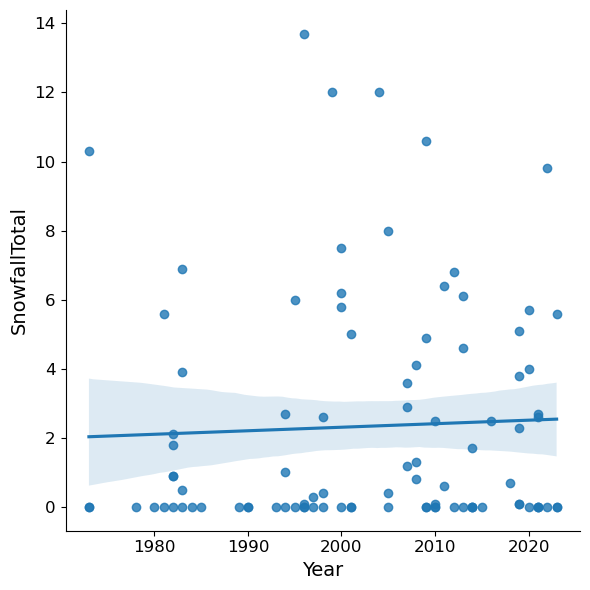

In [19]:
seaborn.lmplot( x="Year", y="SnowfallTotal", data=closure_weather, height = 6)

/Users/lindsayperkins/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


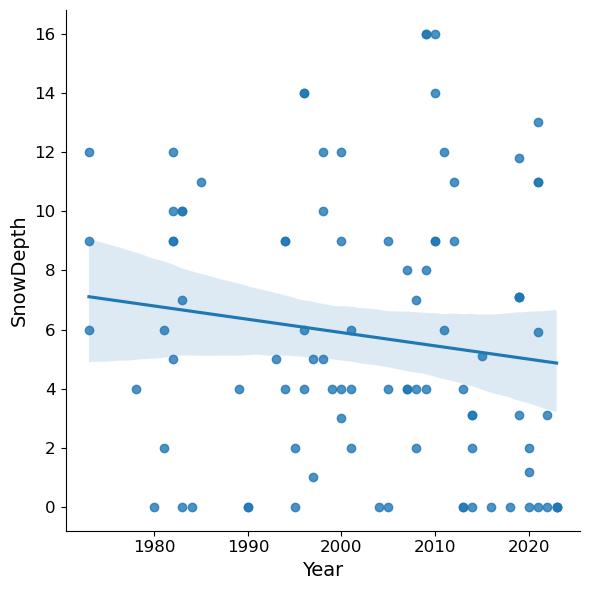

In [20]:
seaborn.lmplot( x="Year", y="SnowDepth", data=closure_weather, height = 6)

/Users/lindsayperkins/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


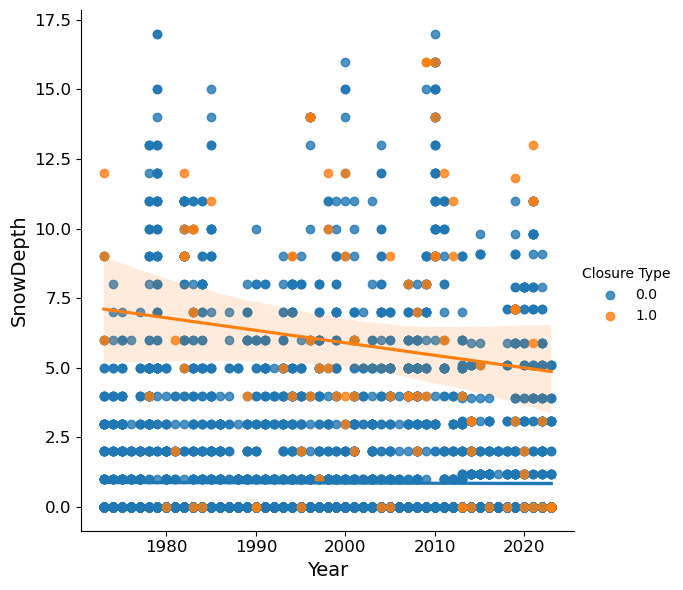

In [21]:
seaborn.lmplot( x="Year", y="SnowDepth", hue ="Closure Type",data = full, height = 6)

/Users/lindsayperkins/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


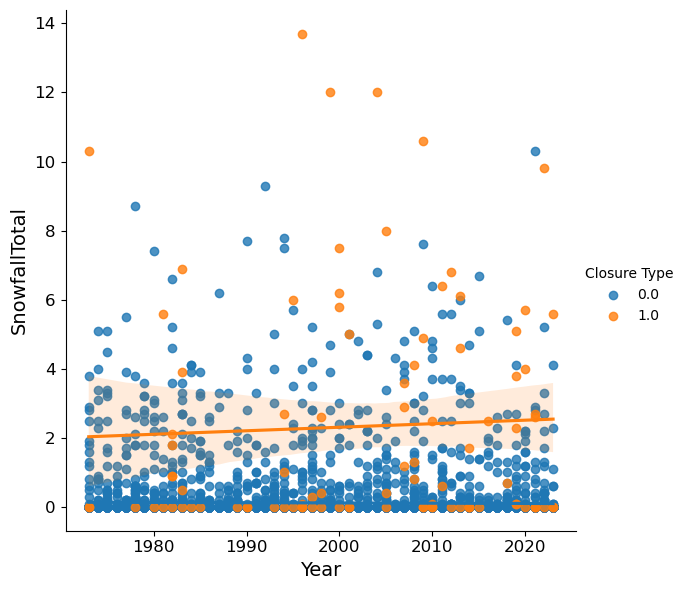

In [22]:
seaborn.lmplot( x="Year", y="SnowfallTotal", hue ="Closure Type",data = full, height = 6)

<Axes: xlabel='Day', ylabel='Month'>

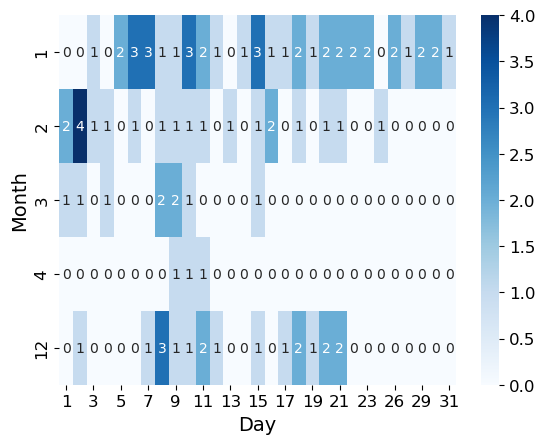

In [23]:
pivot_table = closure_weather.pivot_table(index = "Month", columns = "Day", aggfunc='size', fill_value=0)
seaborn.heatmap(pivot_table, annot=True, cmap='Blues', fmt ='d')

/Users/lindsayperkins/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


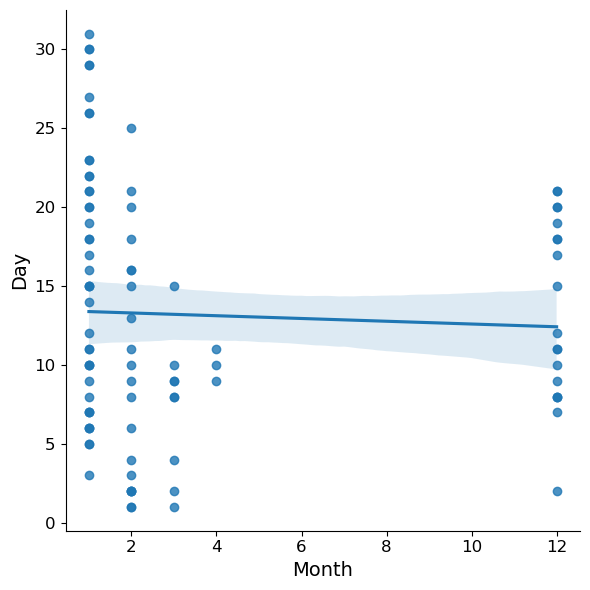

In [24]:
seaborn.lmplot( x="Month", y="Day", data=closure_weather, height=6)

In [25]:
full=full.drop(columns = 'Station')

In [26]:
full.corr()['Closure Type'].sort_values()

MaxTemp                    -0.157518
MinTemp                    -0.144433
Previous_MaxTemp           -0.134304
Previous_MinTemp           -0.126218
3DayVector_MaxTemp         -0.066002
Month                      -0.056005
3DayVector_MinTemp         -0.052787
Day                        -0.026102
HighWinds                  -0.004166
Thunder                    -0.000940
Hail                        0.005572
Day of the Week             0.015206
Mist                        0.019657
School Year                 0.034139
Year                        0.035224
Fog/IceFog/FreezingFog      0.038459
WaterEqGroundSnow           0.058473
PrecipitationTotal          0.080738
Ice/Sleet                   0.104383
Glaze                       0.113957
IceFog                      0.122171
Previous_SnowDepth          0.143463
Previous Early Dismissal    0.175658
3DayVector_SnowfallTotal    0.177962
SnowDepth                   0.222745
3DayVector_SnowDepth        0.224035
Snow Days This Year         0.233678
P

In [27]:
ready = full.drop(columns=[ 'Thunder', 'Day','Day of the Week' , 'Hail', 'HighWinds', 'Fog/IceFog/FreezingFog', 'Mist', 'School Year', 'Year' ])

In [28]:
ready.corr()['Closure Type'].sort_values()

MaxTemp                    -0.157518
MinTemp                    -0.144433
Previous_MaxTemp           -0.134304
Previous_MinTemp           -0.126218
3DayVector_MaxTemp         -0.066002
Month                      -0.056005
3DayVector_MinTemp         -0.052787
WaterEqGroundSnow           0.058473
PrecipitationTotal          0.080738
Ice/Sleet                   0.104383
Glaze                       0.113957
IceFog                      0.122171
Previous_SnowDepth          0.143463
Previous Early Dismissal    0.175658
3DayVector_SnowfallTotal    0.177962
SnowDepth                   0.222745
3DayVector_SnowDepth        0.224035
Snow Days This Year         0.233678
Previous_SnowfallTotal      0.242130
SnowfallTotal               0.323925
Closure Type                1.000000
Name: Closure Type, dtype: float64

<Axes: >

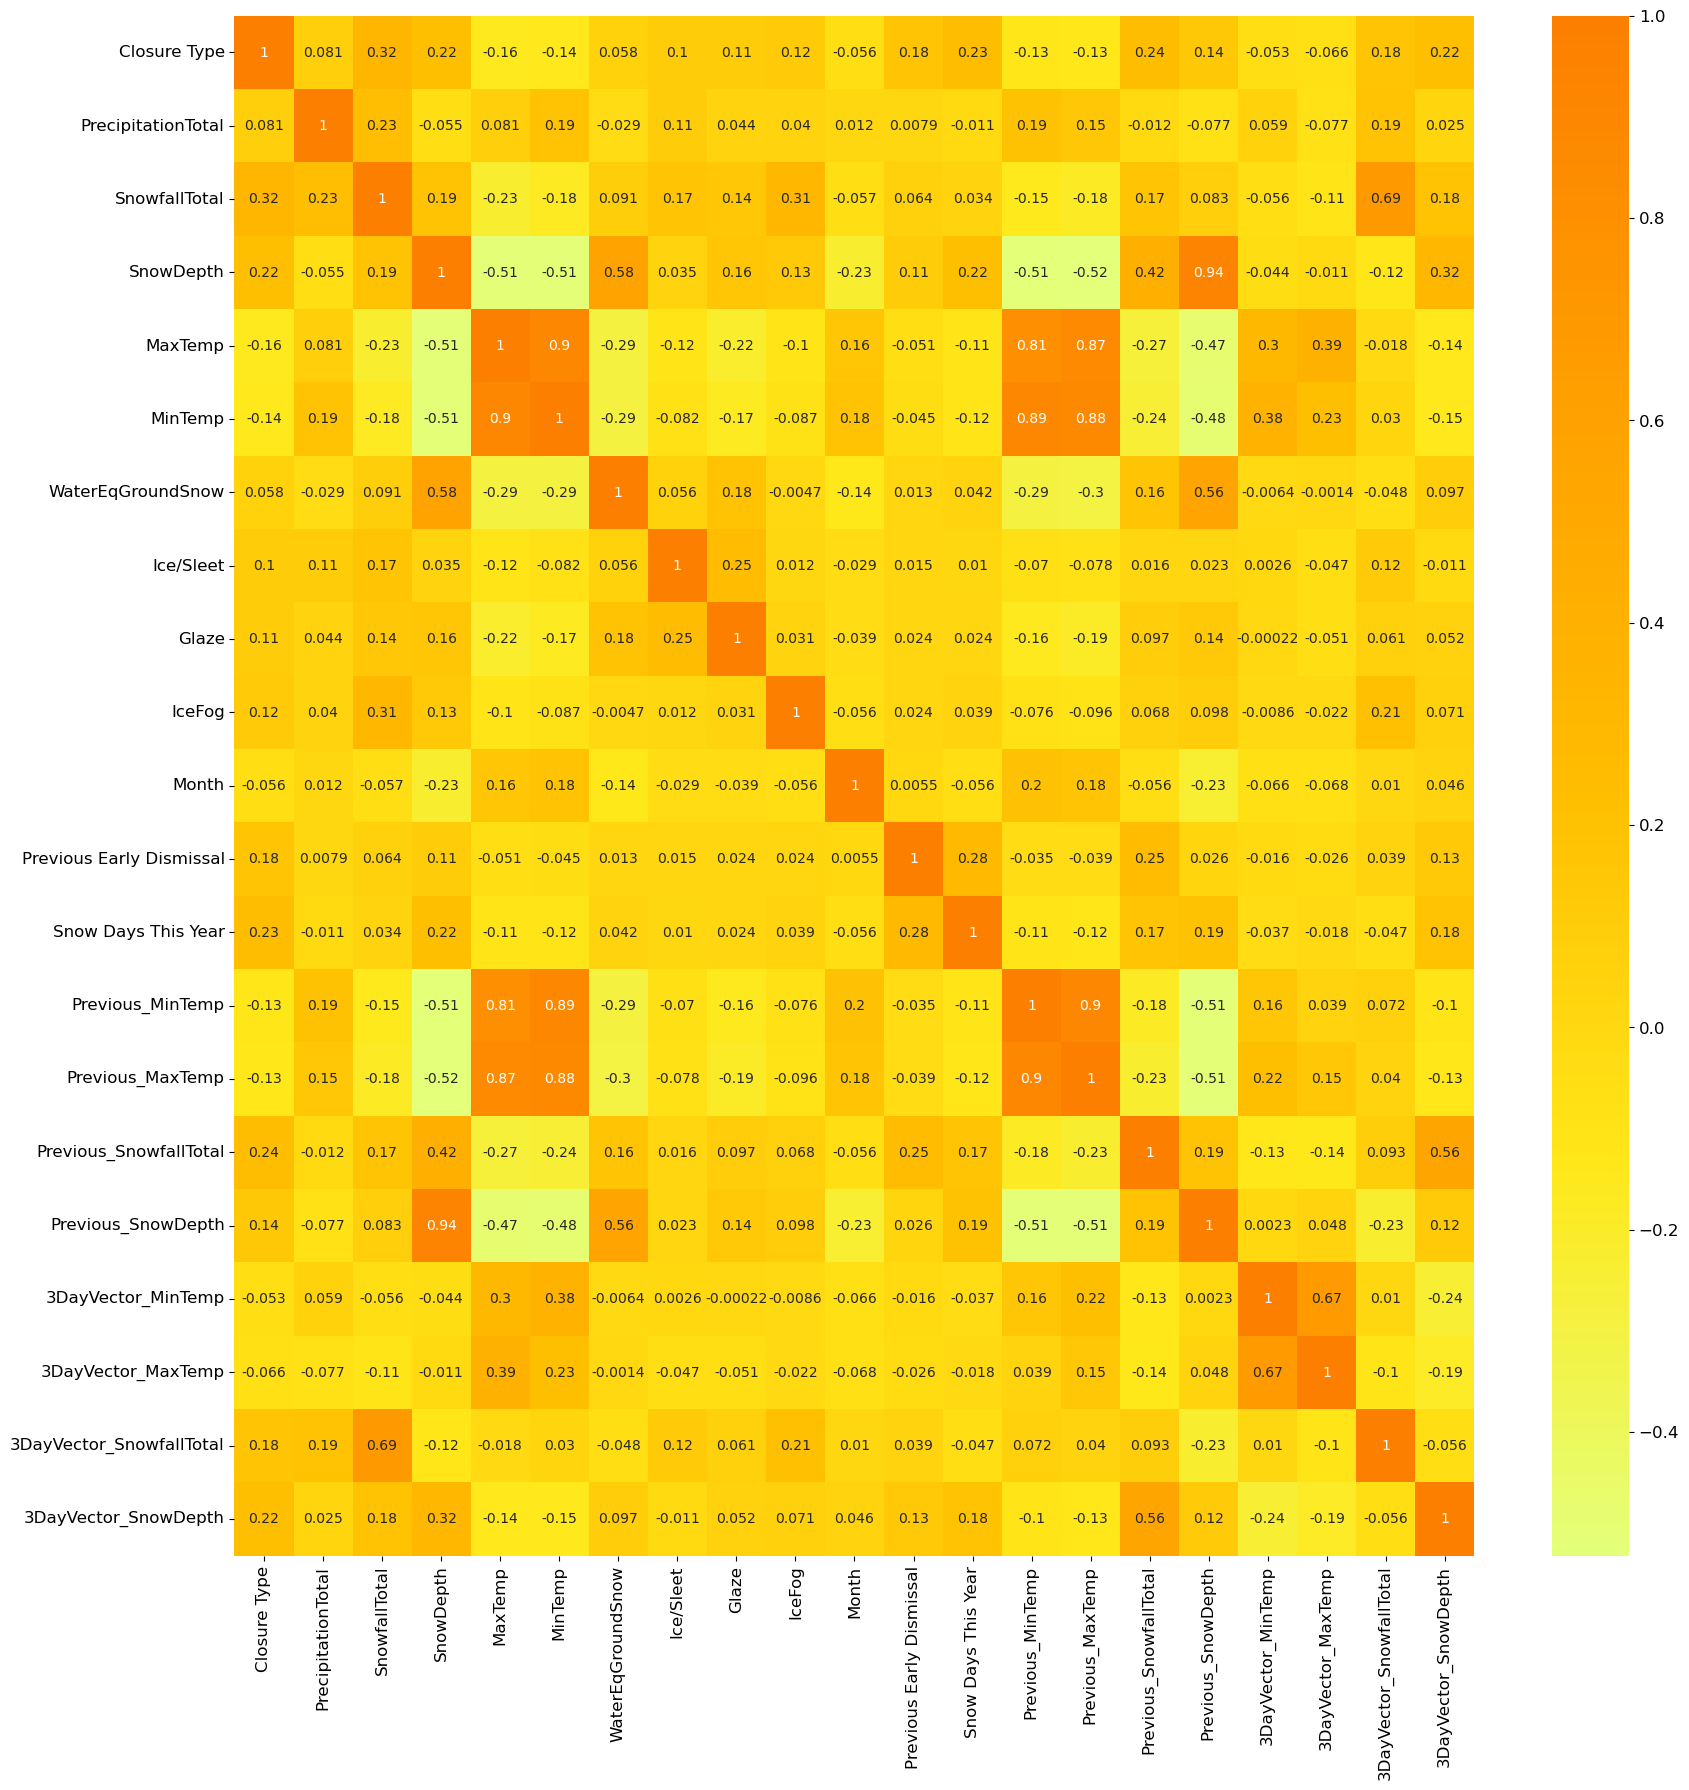

In [29]:
plt.figure(figsize=(20,20))
corr = ready.corr()
seaborn.heatmap(corr, cmap = 'Wistia', annot= True)

# data splitting

In [30]:
X = ready.drop(['Closure Type'], axis = 1)
y = ready['Closure Type']

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X,y, stratify=y, random_state = 42)

# Model 1: Logistic Regression

In [32]:
from sklearn.linear_model import LogisticRegression
log_reg = LogisticRegression(random_state=42, class_weight='balanced')
log_reg.fit(X_train, y_train)

from sklearn.model_selection import cross_val_score
scores = cross_val_score(log_reg, X_train, y_train, cv=10)
score = scores.mean()

y_pred = log_reg.predict(X_test)

print ('Cross validation score for Logistic Regression Model is ' , score)

Cross validation score for Logistic Regression Model is  0.9078120948924034


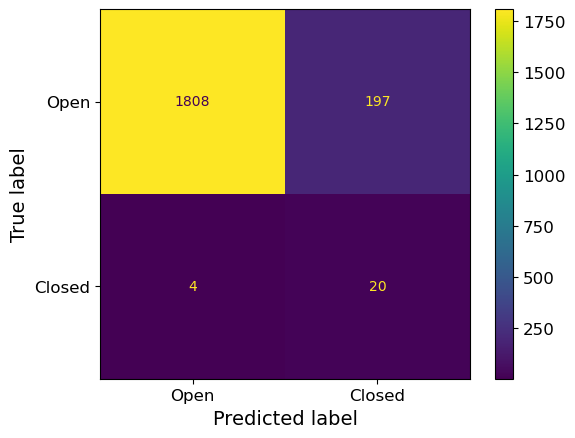

Test set accuracy score for Logistic Regression Model is  0.9009364218827008
Test set recall score for Logistic Regression Model is  0.8333333333333334
Test set precision score for Logistic Regression Model is  0.09216589861751152
Test set F1 score for Logistic Regression Model is  0.16597510373443983


In [33]:
import matplotlib.pyplot as plt
import numpy
from sklearn import metrics

confusion_matrix = metrics.confusion_matrix(y_test, y_pred)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ['Open', 'Closed'])

cm_display.plot()
plt.show()

from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_test, y_pred)

from sklearn.metrics import recall_score
recall = recall_score(y_test, y_pred)

from sklearn.metrics import precision_score
precision = precision_score(y_test, y_pred)

from sklearn.metrics import f1_score
f1 = f1_score(y_test, y_pred)

print ('Test set accuracy score for Logistic Regression Model is ' , accuracy)
print ('Test set recall score for Logistic Regression Model is ' , recall)
print ('Test set precision score for Logistic Regression Model is ' , precision)
print ('Test set F1 score for Logistic Regression Model is ' , f1)

# Model 2: Decision Tree

In [34]:
#find best parameters
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, recall_score, f1_score
from sklearn.datasets import make_classification

dt_classifier = DecisionTreeClassifier(random_state=42, class_weight='balanced')

param_grid = {
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2, 4],
    'criterion': ['gini', 'entropy']
}

# Define the scoring metric (recall in this case)
scoring1 = {'Recall': make_scorer(recall_score)}
scoring2 = {'F1': make_scorer(f1_score)}

# Perform grid search with cross-validation
grid_search1 = GridSearchCV(estimator=dt_classifier, param_grid=param_grid, scoring=scoring1, cv=5, refit='Recall')
grid_search1.fit(X_train, y_train)
grid_search2 = GridSearchCV(estimator=dt_classifier, param_grid=param_grid, scoring=scoring2, cv=5, refit='F1')
grid_search2.fit(X_train, y_train)

# Print the best parameters found
print("Best parameters found for recall:")
print(grid_search1.best_params_)
print("Best parameters found for f1:")
print(grid_search2.best_params_)

Best parameters found for recall:
{'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 2}
Best parameters found for f1:
{'criterion': 'gini', 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 5}


In [35]:
dt_model = DecisionTreeClassifier(criterion= 'gini', max_depth= 10, min_samples_leaf= 1, min_samples_split=5, random_state=42)
dt_model.fit(X_train, y_train)

from sklearn.model_selection import cross_val_score
scores = cross_val_score(dt_model, X_train, y_train, cv=10)
scores.mean()
score2=scores.mean()

y_pred2 = dt_model.predict(X_test)

print ('Cross validation score for Decision Tree Model is ' , score2)

Cross validation score for Decision Tree Model is  0.9870171117448795


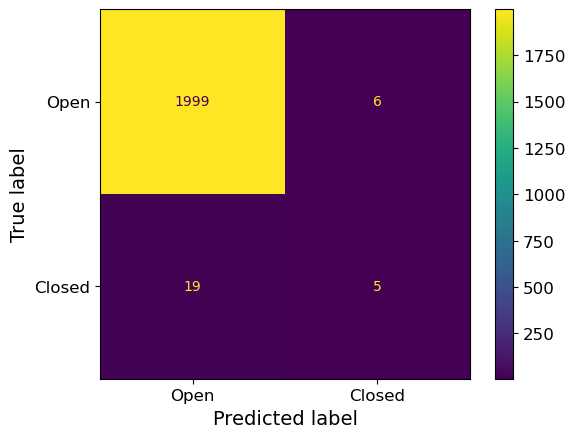

Test set accuracy score for Decision Tree Model is  0.9876786594381469
Test set recall score for Decision Tree Model is  0.20833333333333334
Test set precision score for Decision Tree Model is  0.45454545454545453
Test set F1 score for Decision Tree Model is  0.28571428571428575


In [36]:
import matplotlib.pyplot as plt
import numpy
from sklearn import metrics

confusion_matrix2 = metrics.confusion_matrix(y_test, y_pred2)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix2, display_labels = ['Open', 'Closed'])

cm_display.plot()
plt.show()

from sklearn.metrics import accuracy_score
accuracy2 = accuracy_score(y_test, y_pred2)

from sklearn.metrics import recall_score
recall2 = recall_score(y_test, y_pred2)

from sklearn.metrics import precision_score
precision2 = precision_score(y_test, y_pred2)

from sklearn.metrics import f1_score
f12 = f1_score(y_test, y_pred2)

print ('Test set accuracy score for Decision Tree Model is ' , accuracy2)
print ('Test set recall score for Decision Tree Model is ' , recall2)
print ('Test set precision score for Decision Tree Model is ' , precision2)
print ('Test set F1 score for Decision Tree Model is ' , f12)

# Model 3: Random Forest

In [37]:
#find best parameters
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, recall_score
from sklearn.datasets import make_classification

rf_classifier = RandomForestClassifier(random_state=42, class_weight='balanced')

param_grid = {
    'n_estimators': [100, 150],
    'max_depth': [None, 5],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2,4],
    'criterion': ['gini', 'entropy']
}

# Define the scoring metric (recall in this case)
scoring1 = {'Recall': make_scorer(recall_score)}
scoring2 = {'F1': make_scorer(f1_score)}

# Perform grid search with cross-validation
grid_search1 = GridSearchCV(estimator=rf_classifier, param_grid=param_grid, scoring=scoring1, cv=5, refit='Recall')
grid_search1.fit(X_train, y_train)
grid_search2 = GridSearchCV(estimator=rf_classifier, param_grid=param_grid, scoring=scoring2, cv=5, refit='F1')
grid_search2.fit(X_train, y_train)

# Print the best parameters found
print("Best parameters found for recall:")
print(grid_search1.best_params_)
print("Best parameters found for f1:")
print(grid_search2.best_params_)

Best parameters found for recall:
{'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 100}
Best parameters found for f1:
{'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 100}


In [38]:
rnd_clf = RandomForestClassifier(n_estimators = 100, criterion = 'entropy', max_depth = 5, min_samples_leaf = 4, min_samples_split =2, random_state=42,class_weight='balanced')
rnd_clf.fit(X_train, y_train)

from sklearn.model_selection import cross_val_score
scores = cross_val_score(rnd_clf, X_train, y_train, cv=10)
scores.mean()
score3=scores.mean()

y_pred3 = rnd_clf.predict(X_test)

print ('Cross validation score for Random Forest Model is ' , score3)

Cross validation score for Random Forest Model is  0.9676246110967075


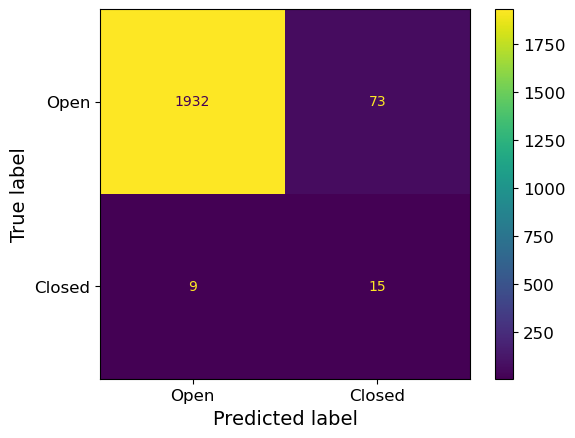

Test set accuracy score for Random Forest Model is  0.9595860029571217
Test set recall score for Random Forest Model is  0.625
Test set precision score for Random Forest Model is  0.17045454545454544
Test set F1 score for Random Forest Model is  0.26785714285714285


In [39]:
import matplotlib.pyplot as plt
import numpy
from sklearn import metrics

confusion_matrix3 = metrics.confusion_matrix(y_test, y_pred3)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix3, display_labels = ['Open', 'Closed'])

cm_display.plot()
plt.show()

from sklearn.metrics import accuracy_score
accuracy3= accuracy_score(y_test, y_pred3)

from sklearn.metrics import recall_score
recall3= recall_score(y_test, y_pred3)

from sklearn.metrics import precision_score
precision3= precision_score(y_test, y_pred3)

from sklearn.metrics import f1_score
f13= f1_score(y_test, y_pred3)

print ('Test set accuracy score for Random Forest Model is ' , accuracy3)
print ('Test set recall score for Random Forest Model is ' , recall3)
print ('Test set precision score for Random Forest Model is ' , precision3)
print ('Test set F1 score for Random Forest Model is ' , f13)

# creating subset of data with hourly data available

In [40]:
#add hourly data max precipitation rates

hourly['time']= hourly['DATE'].dt.hour
hourly['DATE']=hourly['DATE'].dt.date

max_precipitation = hourly.groupby('DATE').apply(lambda x: x.loc[x['HPCP'].idxmax()])
max_precipitation = max_precipitation[['DATE', 'time', 'HPCP']]

max_precipitation['Max Precip. Time'] = max_precipitation['time'].astype('int')
max_precipitation['Max Precip. Rate']= max_precipitation['HPCP']

max_precipitation = max_precipitation.drop(columns = ['time', 'HPCP'])
max_precipitation.reset_index(drop=True, inplace=True)
max_precipitation['DATE']=pd.to_datetime(max_precipitation['DATE'])

max_precipitation

,DATE,Max Precip. Time,Max Precip. Rate
0,1973-01-01,1,0.00
1,1973-01-03,13,0.18
2,1973-01-07,23,0.01
3,1973-01-08,1,0.01
4,1973-01-21,6,0.07
...,...,...,...
5899,2013-12-24,17,0.01
5900,2013-12-25,0,0.01
5901,2013-12-29,0,0.00
5902,2013-12-30,12,0.03


In [41]:
whourly = pd.merge(school, max_precipitation, how='inner', on='DATE')
print(whourly['Closure Type'].value_counts())
#53 closures to look at now instead of 94

Closure Type
0.0    2567
1.0      53
Name: count, dtype: int64


In [42]:
missing_dates2=date_range[~date_range.isin(whourly['DATE'])]
winter_missing_dates2 = missing_dates2[missing_dates2.month.isin([10,11,12,1,2,3,4,5])]
print(missing_dates2, winter_missing_dates2)
print(whourly['Closure Type'].value_counts())
#10826 missing winter weather days
#53 closures to look at now instead of 94

DatetimeIndex(['1961-01-01', '1961-01-02', '1961-01-03', '1961-01-04',
               '1961-01-05', '1961-01-06', '1961-01-07', '1961-01-08',
               '1961-01-09', '1961-01-10',
               ...
               '2021-12-22', '2021-12-23', '2021-12-24', '2021-12-25',
               '2021-12-26', '2021-12-27', '2021-12-28', '2021-12-29',
               '2021-12-30', '2021-12-31'],
              dtype='datetime64[ns]', length=19660, freq=None) DatetimeIndex(['1961-01-01', '1961-01-02', '1961-01-03', '1961-01-04',
               '1961-01-05', '1961-01-06', '1961-01-07', '1961-01-08',
               '1961-01-09', '1961-01-10',
               ...
               '2021-12-22', '2021-12-23', '2021-12-24', '2021-12-25',
               '2021-12-26', '2021-12-27', '2021-12-28', '2021-12-29',
               '2021-12-30', '2021-12-31'],
              dtype='datetime64[ns]', length=12218, freq=None)
Closure Type
0.0    2567
1.0      53
Name: count, dtype: int64


In [43]:
#create previous day's max precip. rate and time
whourly['Previous Max Precip. Rate'] = whourly['Max Precip. Rate'].shift(1)
whourly['Previous Max Precip. Time'] = whourly['Max Precip. Time'].shift(1)

whourly.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2620 entries, 0 to 2619
Data columns (total 41 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   DATE                       2620 non-null   datetime64[ns]
 1   Closure Type               2620 non-null   float64       
 2   Station                    2620 non-null   object        
 3   PrecipitationTotal         2620 non-null   float64       
 4   SnowfallTotal              2620 non-null   float64       
 5   SnowDepth                  2620 non-null   float64       
 6   MaxTemp                    2620 non-null   float64       
 7   MinTemp                    2620 non-null   float64       
 8   WaterEqGroundSnow          2620 non-null   float64       
 9   Fog/IceFog/FreezingFog     2620 non-null   float64       
 10  Thunder                    2620 non-null   float64       
 11  Ice/Sleet                  2620 non-null   float64       
 12  Hail  

In [44]:
whourly = whourly.drop(columns=['DATE', 'School Year', 'MinTempChange', 'MaxTempChange', 'SnowfallTotalChange', 'SnowDepthChange', 'Closure_shift', 'Station'])

# data correlations and more drops

In [45]:
whourly.corr()['Closure Type'].sort_values()

MaxTemp                     -0.179523
Previous_MaxTemp            -0.165940
MinTemp                     -0.164808
Previous_MinTemp            -0.150440
Max Precip. Time            -0.061064
Month                       -0.058675
3DayVector_MinTemp          -0.053722
3DayVector_MaxTemp          -0.048779
Day                         -0.032065
Previous Max Precip. Rate   -0.028104
Thunder                     -0.025152
Max Precip. Rate            -0.017015
HighWinds                   -0.009747
Hail                        -0.006873
Previous Max Precip. Time    0.007281
Day of the Week              0.015764
Mist                         0.018214
Fog/IceFog/FreezingFog       0.020228
Year                         0.041123
PrecipitationTotal           0.064918
WaterEqGroundSnow            0.076368
Ice/Sleet                    0.111137
Glaze                        0.115158
Previous_SnowDepth           0.163589
IceFog                       0.177955
Snow Days This Year          0.229011
Previous Ear

In [46]:
ready =whourly.drop(columns=['3DayVector_MaxTemp', 'Thunder', 'Day', 'Day of the Week', 'Previous Max Precip. Rate', 'Hail', 'HighWinds',  'Previous Max Precip. Time', 'Mist', 'Year', 'Fog/IceFog/FreezingFog', 'Max Precip. Rate'])

In [47]:
ready.corr()['Closure Type'].sort_values()

MaxTemp                    -0.179523
Previous_MaxTemp           -0.165940
MinTemp                    -0.164808
Previous_MinTemp           -0.150440
Max Precip. Time           -0.061064
Month                      -0.058675
3DayVector_MinTemp         -0.053722
PrecipitationTotal          0.064918
WaterEqGroundSnow           0.076368
Ice/Sleet                   0.111137
Glaze                       0.115158
Previous_SnowDepth          0.163589
IceFog                      0.177955
Snow Days This Year         0.229011
Previous Early Dismissal    0.237739
3DayVector_SnowfallTotal    0.242429
SnowDepth                   0.272621
Previous_SnowfallTotal      0.274631
3DayVector_SnowDepth        0.296602
SnowfallTotal               0.350225
Closure Type                1.000000
Name: Closure Type, dtype: float64

# resplit data (w/ hourly)

In [48]:
X = ready.drop(['Closure Type'], axis = 1)
y = ready['Closure Type']

In [49]:
X_train, X_test, y_train, y_test = train_test_split(X,y, stratify=y, random_state = 42)

# Model 1: Logistic Regression (w/ hourly data)

In [50]:
from sklearn.linear_model import LogisticRegression
log_reg = LogisticRegression(random_state=42, class_weight='balanced')
log_reg.fit(X_train, y_train)

from sklearn.model_selection import cross_val_score
scores = cross_val_score(log_reg, X_train, y_train, cv=10)
score = scores.mean()

y_pred = log_reg.predict(X_test)

print ('Cross validation score for Logistic Regression Model is ' , score)

Cross validation score for Logistic Regression Model is  0.891103801926862


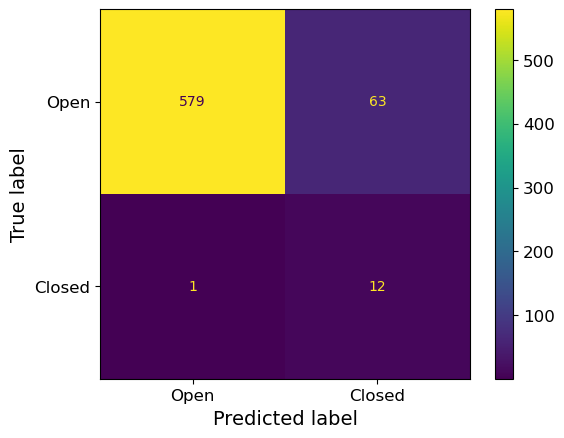

Test set accuracy score for Logistic Regression Model is  0.9022900763358779
Test set recall score for Logistic Regression Model is  0.9230769230769231
Test set precision score for Logistic Regression Model is  0.16
Test set F1 score for Logistic Regression Model is  0.27272727272727276


In [51]:
import matplotlib.pyplot as plt
import numpy
from sklearn import metrics

confusion_matrix = metrics.confusion_matrix(y_test, y_pred)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ['Open', 'Closed'])

cm_display.plot()
plt.show()

from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_test, y_pred)

from sklearn.metrics import recall_score
recall = recall_score(y_test, y_pred)

from sklearn.metrics import precision_score
precision = precision_score(y_test, y_pred)

from sklearn.metrics import f1_score
f1 = f1_score(y_test, y_pred)

print ('Test set accuracy score for Logistic Regression Model is ' , accuracy)
print ('Test set recall score for Logistic Regression Model is ' , recall)
print ('Test set precision score for Logistic Regression Model is ' , precision)
print ('Test set F1 score for Logistic Regression Model is ' , f1)

# Model 2: Decision Tree (w/ hourly data)

In [52]:
#find best parameters
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, recall_score, f1_score
from sklearn.datasets import make_classification

dt_classifier = DecisionTreeClassifier(random_state=42, class_weight='balanced')

param_grid = {
    'max_depth': [None, 5, 10, 15],
    'min_samples_split': [2, 5, 10, 15],
    'min_samples_leaf': [1, 2, 4],
    'criterion': ['gini', 'entropy']
}

# Define the scoring metric (recall in this case)
scoring1 = {'Recall': make_scorer(recall_score)}
scoring2 = {'F1': make_scorer(f1_score)}

# Perform grid search with cross-validation
grid_search1 = GridSearchCV(estimator=dt_classifier, param_grid=param_grid, scoring=scoring1, cv=5, refit='Recall')
grid_search1.fit(X_train, y_train)
grid_search2 = GridSearchCV(estimator=dt_classifier, param_grid=param_grid, scoring=scoring2, cv=5, refit='F1')
grid_search2.fit(X_train, y_train)

# Print the best parameters found
print("Best parameters found for recall:")
print(grid_search1.best_params_)
print("Best parameters found for f1:")
print(grid_search2.best_params_)

Best parameters found for recall:
{'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 4, 'min_samples_split': 2}
Best parameters found for f1:
{'criterion': 'entropy', 'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 10}


In [53]:
dt_model = DecisionTreeClassifier(criterion = 'entropy', max_depth = None, min_samples_leaf = 2, min_samples_split =10, random_state=42, class_weight='balanced')
dt_model.fit(X_train, y_train)

from sklearn.model_selection import cross_val_score
scores = cross_val_score(dt_model, X_train, y_train, cv=10)
scores.mean()
score2=scores.mean()

y_pred2 = dt_model.predict(X_test)

print ('Cross validation score for Decision Tree Model is ' , score2)

Cross validation score for Decision Tree Model is  0.9659121516626955


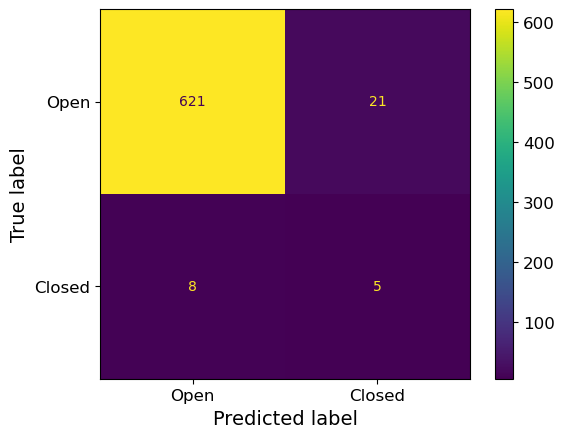

Test set accuracy score for Decision Tree Model is  0.9557251908396946
Test set recall score for Decision Tree Model is  0.38461538461538464
Test set precision score for Decision Tree Model is  0.19230769230769232
Test set F1 score for Decision Tree Model is  0.2564102564102564


In [54]:
import matplotlib.pyplot as plt
import numpy
from sklearn import metrics

confusion_matrix2 = metrics.confusion_matrix(y_test, y_pred2)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix2, display_labels = ['Open', 'Closed'])

cm_display.plot()
plt.show()

from sklearn.metrics import accuracy_score
accuracy2 = accuracy_score(y_test, y_pred2)

from sklearn.metrics import recall_score
recall2 = recall_score(y_test, y_pred2)

from sklearn.metrics import precision_score
precision2 = precision_score(y_test, y_pred2)

from sklearn.metrics import f1_score
f12 = f1_score(y_test, y_pred2)

print ('Test set accuracy score for Decision Tree Model is ' , accuracy2)
print ('Test set recall score for Decision Tree Model is ' , recall2)
print ('Test set precision score for Decision Tree Model is ' , precision2)
print ('Test set F1 score for Decision Tree Model is ' , f12)

# Model 3: Random Forest (w/ hourly data)

In [55]:
#find best parameters
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, recall_score
from sklearn.datasets import make_classification

rf_classifier = RandomForestClassifier(random_state=42, class_weight='balanced')

param_grid = {
    'n_estimators': [100, 150],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2,4],
    'criterion': ['gini', 'entropy']
}

# Define the scoring metric (recall in this case)
scoring1 = {'Recall': make_scorer(recall_score)}
scoring2 = {'F1': make_scorer(f1_score)}

# Perform grid search with cross-validation
grid_search1 = GridSearchCV(estimator=rf_classifier, param_grid=param_grid, scoring=scoring1, cv=5, refit='Recall')
grid_search1.fit(X_train, y_train)
grid_search2 = GridSearchCV(estimator=rf_classifier, param_grid=param_grid, scoring=scoring2, cv=5, refit='F1')
grid_search2.fit(X_train, y_train)

# Print the best parameters found
print("Best parameters found for recall:")
print(grid_search1.best_params_)
print("Best parameters found for f1:")
print(grid_search2.best_params_)

Best parameters found for recall:
{'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 150}
Best parameters found for f1:
{'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 150}


In [56]:
rnd_clf = RandomForestClassifier(n_estimators = 150, criterion = 'gini', max_depth = 5, min_samples_leaf = 2, min_samples_split =5, random_state=42,class_weight='balanced')
rnd_clf.fit(X_train, y_train)

from sklearn.model_selection import cross_val_score
scores = cross_val_score(rnd_clf, X_train, y_train, cv=10)
scores.mean()
score3=scores.mean()

y_pred3 = rnd_clf.predict(X_test)

print ('Cross validation score for Random Forest Model is ' , score3)

Cross validation score for Random Forest Model is  0.9679270693048793


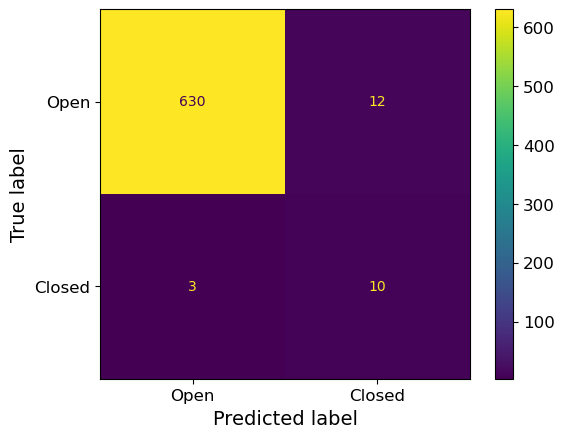

Test set accuracy score for Random Forest Model is  0.9770992366412213
Test set recall score for Random Forest Model is  0.7692307692307693
Test set precision score for Random Forest Model is  0.45454545454545453
Test set F1 score for Random Forest Model is  0.5714285714285714


In [57]:
import matplotlib.pyplot as plt
import numpy
from sklearn import metrics

confusion_matrix3 = metrics.confusion_matrix(y_test, y_pred3)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix3, display_labels = ['Open', 'Closed'])

cm_display.plot()
plt.show()

from sklearn.metrics import accuracy_score
accuracy3 = accuracy_score(y_test, y_pred3)

from sklearn.metrics import recall_score
recall3 = recall_score(y_test, y_pred3)

from sklearn.metrics import precision_score
precision3 = precision_score(y_test, y_pred3)

from sklearn.metrics import f1_score
f13 = f1_score(y_test, y_pred3)

print ('Test set accuracy score for Random Forest Model is ' , accuracy3)
print ('Test set recall score for Random Forest Model is ' , recall3)
print ('Test set precision score for Random Forest Model is ' , precision3)
print ('Test set F1 score for Random Forest Model is ' , f13)

# creating subset of just extreme weather data and school closures (more balanced data set)

In [58]:
snow = full['SnowfallTotal']>1
temp=full['MinTemp']<32
closure=full['Closure Type'] == 1

extreme_subset = full[snow|temp|closure]

extreme_subset['Closure Type'].value_counts()

Closure Type
0.0    3831
1.0      94
Name: count, dtype: int64

# data correlations and more drops

In [59]:
extreme_subset.corr()['Closure Type'].sort_values()

MaxTemp                    -0.153496
MinTemp                    -0.119885
Previous_MaxTemp           -0.105711
Previous_MinTemp           -0.087746
3DayVector_MaxTemp         -0.068881
Month                      -0.049777
3DayVector_MinTemp         -0.035129
Day                        -0.027482
Day of the Week             0.022164
Mist                        0.028388
WaterEqGroundSnow           0.036243
Hail                        0.047447
School Year                 0.052206
Year                        0.053618
Fog/IceFog/FreezingFog      0.064164
Thunder                     0.094116
Glaze                       0.096385
IceFog                      0.110577
Ice/Sleet                   0.111843
Previous_SnowDepth          0.113251
Previous Early Dismissal    0.172428
3DayVector_SnowfallTotal    0.181943
SnowDepth                   0.198491
Previous_SnowfallTotal      0.226331
3DayVector_SnowDepth        0.229417
Snow Days This Year         0.238978
PrecipitationTotal          0.269907
S

In [60]:
ready =extreme_subset.drop(columns=['Day', 'Day of the Week', '3DayVector_MinTemp','Hail', 'HighWinds', 'Mist', 'WaterEqGroundSnow', 'Month'])

In [61]:
ready.corr()['Closure Type'].sort_values()

MaxTemp                    -0.153496
MinTemp                    -0.119885
Previous_MaxTemp           -0.105711
Previous_MinTemp           -0.087746
3DayVector_MaxTemp         -0.068881
School Year                 0.052206
Year                        0.053618
Fog/IceFog/FreezingFog      0.064164
Thunder                     0.094116
Glaze                       0.096385
IceFog                      0.110577
Ice/Sleet                   0.111843
Previous_SnowDepth          0.113251
Previous Early Dismissal    0.172428
3DayVector_SnowfallTotal    0.181943
SnowDepth                   0.198491
Previous_SnowfallTotal      0.226331
3DayVector_SnowDepth        0.229417
Snow Days This Year         0.238978
PrecipitationTotal          0.269907
SnowfallTotal               0.310049
Closure Type                1.000000
Name: Closure Type, dtype: float64

# resplit data (for extreme subset)

In [62]:
X = ready.drop(['Closure Type'], axis = 1)
y = ready['Closure Type']

In [63]:
X_train, X_test, y_train, y_test = train_test_split(X,y, stratify=y, random_state = 42)

# Model 1: Logistic Regression (extreme subset)

In [64]:
from sklearn.linear_model import LogisticRegression
log_reg = LogisticRegression(random_state=42, class_weight='balanced')
log_reg.fit(X_train, y_train)

from sklearn.model_selection import cross_val_score
scores = cross_val_score(log_reg, X_train, y_train, cv=10)
score = scores.mean()

y_pred = log_reg.predict(X_test)

print ('Cross validation score for Logistic Regression Model is ' , score)

Cross validation score for Logistic Regression Model is  0.8538890810561514


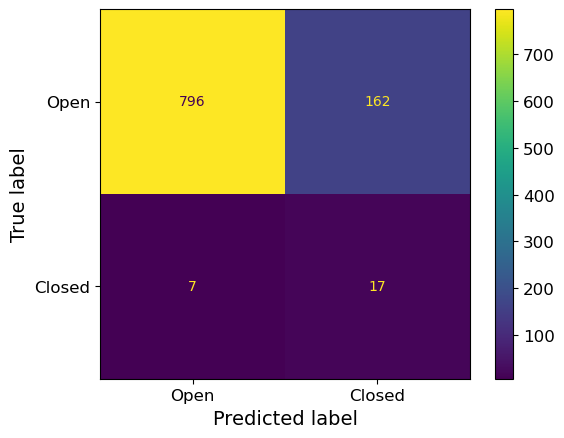

Test set accuracy score for Logistic Regression Model is  0.8279022403258656
Test set recall score for Logistic Regression Model is  0.7083333333333334
Test set precision score for Logistic Regression Model is  0.09497206703910614
Test set F1 score for Logistic Regression Model is  0.16748768472906406


In [65]:
import matplotlib.pyplot as plt
import numpy
from sklearn import metrics

confusion_matrix = metrics.confusion_matrix(y_test, y_pred)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ['Open', 'Closed'])

cm_display.plot()
plt.show()

from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_test, y_pred)

from sklearn.metrics import recall_score
recall = recall_score(y_test, y_pred)

from sklearn.metrics import precision_score
precision = precision_score(y_test, y_pred)

from sklearn.metrics import f1_score
f1 = f1_score(y_test, y_pred)

print ('Test set accuracy score for Logistic Regression Model is ' , accuracy)
print ('Test set recall score for Logistic Regression Model is ' , recall)
print ('Test set precision score for Logistic Regression Model is ' , precision)
print ('Test set F1 score for Logistic Regression Model is ' , f1)

# Model 2: Decision Tree (extreme subset)

In [66]:
#find best parameters
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, recall_score, f1_score
from sklearn.datasets import make_classification

dt_classifier = DecisionTreeClassifier(random_state=42, class_weight='balanced')

param_grid = {
    'max_depth': [None, 5, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'criterion': ['gini', 'entropy']
}

# Define the scoring metric (recall in this case)
scoring1 = {'Recall': make_scorer(recall_score)}
scoring2 = {'F1': make_scorer(f1_score)}

# Perform grid search with cross-validation
grid_search1 = GridSearchCV(estimator=dt_classifier, param_grid=param_grid, scoring=scoring1, cv=5, refit='Recall')
grid_search1.fit(X_train, y_train)
grid_search2 = GridSearchCV(estimator=dt_classifier, param_grid=param_grid, scoring=scoring2, cv=5, refit='F1')
grid_search2.fit(X_train, y_train)

# Print the best parameters found
print("Best parameters found for recall:")
print(grid_search1.best_params_)
print("Best parameters found for f1:")
print(grid_search2.best_params_)

Best parameters found for recall:
{'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 4, 'min_samples_split': 2}
Best parameters found for f1:
{'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 2}


In [67]:
dt_model = DecisionTreeClassifier(criterion = 'gini', max_depth = 5, min_samples_leaf = 1, min_samples_split =2, random_state=42, class_weight='balanced')
dt_model.fit(X_train, y_train)

from sklearn.model_selection import cross_val_score
scores = cross_val_score(dt_model, X_train, y_train, cv=10)
scores.mean()
score2=scores.mean()

y_pred2 = dt_model.predict(X_test)

print ('Cross validation score for Decision Tree Model is ' , score2)

Cross validation score for Decision Tree Model is  0.9143779545716593


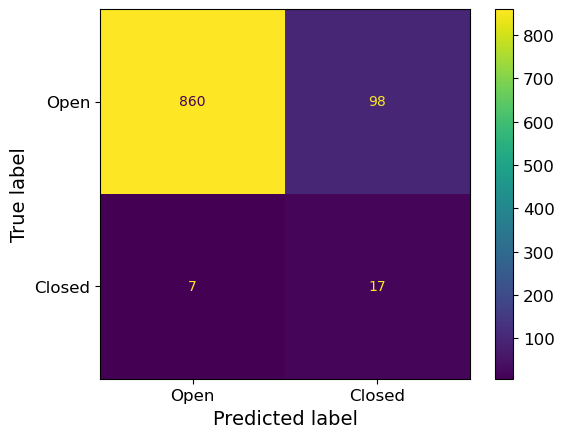

Test set accuracy score for Decision Tree Model is  0.8930753564154786
Test set recall score for Decision Tree Model is  0.7083333333333334
Test set precision score for Decision Tree Model is  0.14782608695652175
Test set F1 score for Decision Tree Model is  0.2446043165467626


In [68]:
import matplotlib.pyplot as plt
import numpy
from sklearn import metrics

confusion_matrix2 = metrics.confusion_matrix(y_test, y_pred2)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix2, display_labels = ['Open', 'Closed'])

cm_display.plot()
plt.show()

from sklearn.metrics import accuracy_score
accuracy2 = accuracy_score(y_test, y_pred2)

from sklearn.metrics import recall_score
recall2 = recall_score(y_test, y_pred2)

from sklearn.metrics import precision_score
precision2 = precision_score(y_test, y_pred2)

from sklearn.metrics import f1_score
f12 = f1_score(y_test, y_pred2)

print ('Test set accuracy score for Decision Tree Model is ' , accuracy2)
print ('Test set recall score for Decision Tree Model is ' , recall2)
print ('Test set precision score for Decision Tree Model is ' , precision2)
print ('Test set F1 score for Decision Tree Model is ' , f12)

# Model 3: Random Forest (extreme subset)

In [69]:
#find best parameters
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, recall_score
from sklearn.datasets import make_classification

rf_classifier = RandomForestClassifier(random_state=42, class_weight='balanced')

param_grid = {
    'n_estimators': [100, 150],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2,4],
    'criterion': ['gini', 'entropy']
}

# Define the scoring metric (recall in this case)
scoring1 = {'Recall': make_scorer(recall_score)}
scoring2 = {'F1': make_scorer(f1_score)}

# Perform grid search with cross-validation
grid_search1 = GridSearchCV(estimator=rf_classifier, param_grid=param_grid, scoring=scoring1, cv=5, refit='Recall')
grid_search1.fit(X_train, y_train)
grid_search2 = GridSearchCV(estimator=rf_classifier, param_grid=param_grid, scoring=scoring2, cv=5, refit='F1')
grid_search2.fit(X_train, y_train)

# Print the best parameters found
print("Best parameters found for recall:")
print(grid_search1.best_params_)
print("Best parameters found for f1:")
print(grid_search2.best_params_)

Best parameters found for recall:
{'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 100}
Best parameters found for f1:
{'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}


In [70]:
rnd_clf = RandomForestClassifier(n_estimators = 100, criterion = 'entropy', max_depth = 5, min_samples_leaf = 2, min_samples_split =2, random_state=42,class_weight='balanced')
rnd_clf.fit(X_train, y_train)

from sklearn.model_selection import cross_val_score
scores = cross_val_score(rnd_clf, X_train, y_train, cv=10)
scores.mean()
score3=scores.mean()

y_pred3 = rnd_clf.predict(X_test)

print ('Cross validation score for Random Forest Model is ' , score3)

Cross validation score for Random Forest Model is  0.960927014873746


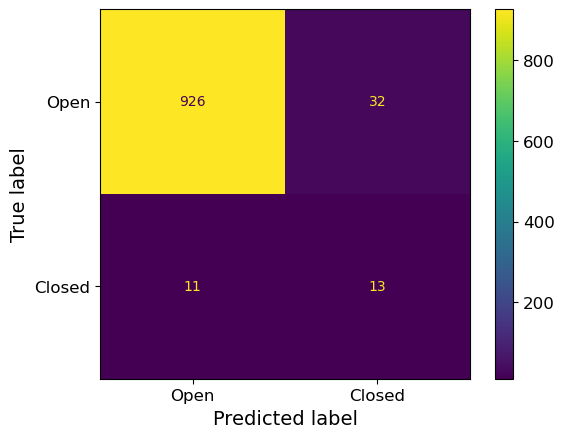

Test set accuracy score for Random Forest Model is  0.9562118126272913
Test set recall score for Random Forest Model is  0.5416666666666666
Test set precision score for Random Forest Model is  0.28888888888888886
Test set F1 score for Random Forest Model is  0.3768115942028985


In [71]:
import matplotlib.pyplot as plt
import numpy
from sklearn import metrics

confusion_matrix3 = metrics.confusion_matrix(y_test, y_pred3)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix3, display_labels = ['Open', 'Closed'])

cm_display.plot()
plt.show()

from sklearn.metrics import accuracy_score
accuracy3 = accuracy_score(y_test, y_pred3)

from sklearn.metrics import recall_score
recall3 = recall_score(y_test, y_pred3)

from sklearn.metrics import precision_score
precision3 = precision_score(y_test, y_pred3)

from sklearn.metrics import f1_score
f13 = f1_score(y_test, y_pred3)

print ('Test set accuracy score for Random Forest Model is ' , accuracy3)
print ('Test set recall score for Random Forest Model is ' , recall3)
print ('Test set precision score for Random Forest Model is ' , precision3)
print ('Test set F1 score for Random Forest Model is ' , f13)

# creating subset of just extreme weather data that also contains hourly data

In [72]:
snow = whourly['SnowfallTotal']>1
temp=whourly['MinTemp']<32
closure=whourly['Closure Type'] == 1

extremehourly_subset = whourly[snow|temp|closure]

extremehourly_subset['Previous Max Precip. Time']= extremehourly_subset['Previous Max Precip. Time'].fillna(0)

extremehourly_subset['Closure Type'].value_counts()

/var/folders/fh/dvn_79bs6b58szfg1vfz4g740000gn/T/ipykernel_5029/2910752394.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  extremehourly_subset['Previous Max Precip. Time']= extremehourly_subset['Previous Max Precip. Time'].fillna(0)


Closure Type
0.0    1094
1.0      53
Name: count, dtype: int64

# data correlations and more drops

In [73]:
extremehourly_subset.corr()['Closure Type'].sort_values()

MaxTemp                     -0.137070
Previous_MaxTemp            -0.100378
MinTemp                     -0.076618
Max Precip. Time            -0.069596
Previous_MinTemp            -0.061268
Month                       -0.041722
3DayVector_MaxTemp          -0.037455
Day                         -0.022935
3DayVector_MinTemp          -0.016863
Mist                         0.025063
Day of the Week              0.032294
Previous Max Precip. Time    0.034039
WaterEqGroundSnow            0.038440
Previous Max Precip. Rate    0.045302
Fog/IceFog/FreezingFog       0.050527
Year                         0.056211
Hail                         0.060055
Glaze                        0.072168
Thunder                      0.100843
Ice/Sleet                    0.106316
Previous_SnowDepth           0.110265
Max Precip. Rate             0.141545
IceFog                       0.150063
3DayVector_SnowfallTotal     0.218930
SnowDepth                    0.228849
Previous Early Dismissal     0.231059
Snow Days Th

In [74]:
ready =extremehourly_subset.drop(columns=['3DayVector_MinTemp', '3DayVector_MaxTemp',  'Day of the Week', 'Previous Max Precip. Rate', 'Day', 'Mist', 'WaterEqGroundSnow', 'Previous Max Precip. Time', 'Month'])

In [75]:
ready.corr()['Closure Type'].sort_values()

MaxTemp                    -0.137070
Previous_MaxTemp           -0.100378
MinTemp                    -0.076618
Max Precip. Time           -0.069596
Previous_MinTemp           -0.061268
Fog/IceFog/FreezingFog      0.050527
Year                        0.056211
Hail                        0.060055
Glaze                       0.072168
Thunder                     0.100843
Ice/Sleet                   0.106316
Previous_SnowDepth          0.110265
Max Precip. Rate            0.141545
IceFog                      0.150063
3DayVector_SnowfallTotal    0.218930
SnowDepth                   0.228849
Previous Early Dismissal    0.231059
Snow Days This Year         0.242848
Previous_SnowfallTotal      0.243485
PrecipitationTotal          0.271204
3DayVector_SnowDepth        0.289792
SnowfallTotal               0.317141
Closure Type                1.000000
HighWinds                        NaN
Name: Closure Type, dtype: float64

In [76]:
ready.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1147 entries, 0 to 2619
Data columns (total 24 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Closure Type              1147 non-null   float64
 1   PrecipitationTotal        1147 non-null   float64
 2   SnowfallTotal             1147 non-null   float64
 3   SnowDepth                 1147 non-null   float64
 4   MaxTemp                   1147 non-null   float64
 5   MinTemp                   1147 non-null   float64
 6   Fog/IceFog/FreezingFog    1147 non-null   float64
 7   Thunder                   1147 non-null   float64
 8   Ice/Sleet                 1147 non-null   float64
 9   Hail                      1147 non-null   float64
 10  Glaze                     1147 non-null   float64
 11  HighWinds                 1147 non-null   float64
 12  IceFog                    1147 non-null   float64
 13  Year                      1147 non-null   int32  
 14  Previous Earl

# resplit data (for extreme hourly subset)

In [77]:
X = ready.drop(['Closure Type'], axis = 1)
y = ready['Closure Type']

In [78]:
X_train, X_test, y_train, y_test = train_test_split(X,y, stratify=y, random_state = 42)

# Model 1: Logistic Regression (extreme hourly subset)

In [79]:
from sklearn.linear_model import LogisticRegression
log_reg = LogisticRegression(random_state=42, class_weight='balanced')
log_reg.fit(X_train, y_train)

from sklearn.model_selection import cross_val_score
scores = cross_val_score(log_reg, X_train, y_train, cv=10)
score = scores.mean()

from sklearn.metrics import accuracy_score
y_pred = log_reg.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print ('Cross validation score for Logistic Regression Model is ' , score)

Cross validation score for Logistic Regression Model is  0.813953488372093


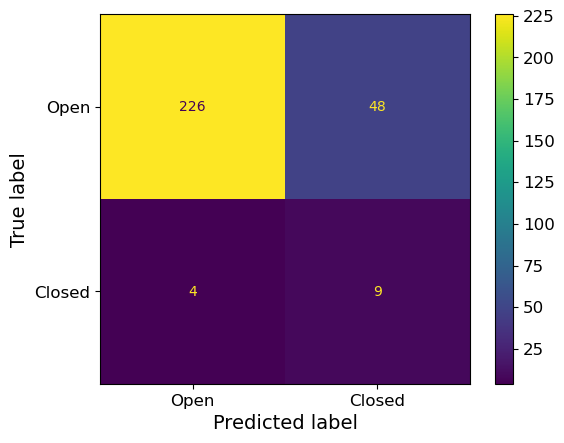

Test set accuracy score for Logistic Regression Model is  0.818815331010453
Test set recall score for Logistic Regression Model is  0.6923076923076923
Test set precision score for Logistic Regression Model is  0.15789473684210525
Test set F1 score for Logistic Regression Model is  0.2571428571428571


In [80]:
import matplotlib.pyplot as plt
import numpy
from sklearn import metrics

confusion_matrix = metrics.confusion_matrix(y_test, y_pred)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ['Open', 'Closed'])

cm_display.plot()
plt.show()

from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_test, y_pred)

from sklearn.metrics import recall_score
recall = recall_score(y_test, y_pred)

from sklearn.metrics import precision_score
precision = precision_score(y_test, y_pred)

from sklearn.metrics import f1_score
f1 = f1_score(y_test, y_pred)

print ('Test set accuracy score for Logistic Regression Model is ' , accuracy)
print ('Test set recall score for Logistic Regression Model is ' , recall)
print ('Test set precision score for Logistic Regression Model is ' , precision)
print ('Test set F1 score for Logistic Regression Model is ' , f1)

# Model 2: Decision Tree (extreme hourly subset)

In [81]:
#find best parameters
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, recall_score, f1_score
from sklearn.datasets import make_classification

dt_classifier = DecisionTreeClassifier(random_state=42, class_weight='balanced')

param_grid = {
    'max_depth': [None, 5, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'criterion': ['gini', 'entropy']
}

# Define the scoring metric (recall in this case)
scoring1 = {'Recall': make_scorer(recall_score)}
scoring2 = {'F1': make_scorer(f1_score)}

# Perform grid search with cross-validation
grid_search1 = GridSearchCV(estimator=dt_classifier, param_grid=param_grid, scoring=scoring1, cv=5, refit='Recall')
grid_search1.fit(X_train, y_train)
grid_search2 = GridSearchCV(estimator=dt_classifier, param_grid=param_grid, scoring=scoring2, cv=5, refit='F1')
grid_search2.fit(X_train, y_train)

# Print the best parameters found
print("Best parameters found for recall:")
print(grid_search1.best_params_)
print("Best parameters found for f1:")
print(grid_search2.best_params_)

Best parameters found for recall:
{'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 5}
Best parameters found for f1:
{'criterion': 'entropy', 'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 5}


In [82]:
dt_model = DecisionTreeClassifier(criterion = 'entropy', max_depth = None, min_samples_leaf = 2, min_samples_split =5, random_state=42, class_weight='balanced')
dt_model.fit(X_train, y_train)

from sklearn.model_selection import cross_val_score
scores = cross_val_score(dt_model, X_train, y_train, cv=10)
scores.mean()
score2=scores.mean()

y_pred2 = dt_model.predict(X_test)

print ('Cross validation score for Decision Tree Model is ' , score2)

Cross validation score for Decision Tree Model is  0.9267441860465115


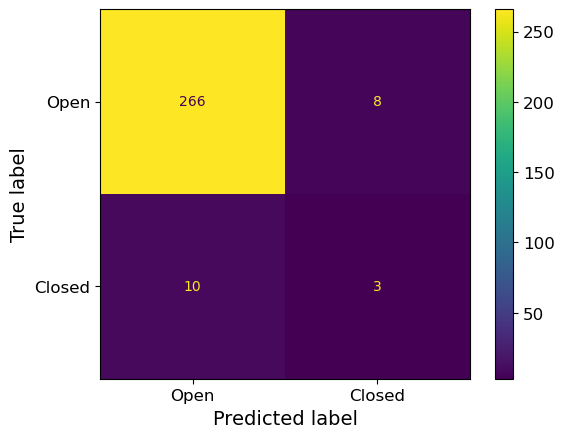

Test set accuracy score for Decision Tree Model is  0.9372822299651568
Test set recall score for Decision Tree Model is  0.23076923076923078
Test set precision score for Decision Tree Model is  0.2727272727272727
Test set F1 score for Decision Tree Model is  0.24999999999999994


In [83]:
import matplotlib.pyplot as plt
import numpy
from sklearn import metrics

confusion_matrix2 = metrics.confusion_matrix(y_test, y_pred2)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix2, display_labels = ['Open', 'Closed'])

cm_display.plot()
plt.show()

from sklearn.metrics import accuracy_score
accuracy2 = accuracy_score(y_test, y_pred2)

from sklearn.metrics import recall_score
recall2 = recall_score(y_test, y_pred2)

from sklearn.metrics import precision_score
precision2 = precision_score(y_test, y_pred2)

from sklearn.metrics import f1_score
f12 = f1_score(y_test, y_pred2)

print ('Test set accuracy score for Decision Tree Model is ' , accuracy2)
print ('Test set recall score for Decision Tree Model is ' , recall2)
print ('Test set precision score for Decision Tree Model is ' , precision2)
print ('Test set F1 score for Decision Tree Model is ' , f12)

# Model 3: Random Forest (extreme hourly subset)

In [84]:
#find best parameters
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, recall_score
from sklearn.datasets import make_classification

rf_classifier = RandomForestClassifier(random_state=42, class_weight='balanced')

param_grid = {
    'n_estimators': [100, 150],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2,4],
    'criterion': ['gini', 'entropy']
}

# Define the scoring metric (recall in this case)
scoring1 = {'Recall': make_scorer(recall_score)}
scoring2 = {'F1': make_scorer(f1_score)}

# Perform grid search with cross-validation
grid_search1 = GridSearchCV(estimator=rf_classifier, param_grid=param_grid, scoring=scoring1, cv=5, refit='Recall')
grid_search1.fit(X_train, y_train)
grid_search2 = GridSearchCV(estimator=rf_classifier, param_grid=param_grid, scoring=scoring2, cv=5, refit='F1')
grid_search2.fit(X_train, y_train)

# Print the best parameters found
print("Best parameters found for recall:")
print(grid_search1.best_params_)
print("Best parameters found for f1:")
print(grid_search2.best_params_)

Best parameters found for recall:
{'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 100}
Best parameters found for f1:
{'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 150}


In [85]:
rnd_clf = RandomForestClassifier(n_estimators = 150, criterion = 'entropy', max_depth = 5, min_samples_leaf = 4, min_samples_split =2, random_state=42,class_weight='balanced')
rnd_clf.fit(X_train, y_train)

from sklearn.model_selection import cross_val_score
scores = cross_val_score(rnd_clf, X_train, y_train, cv=10)
scores.mean()
score3=scores.mean()

y_pred3 = rnd_clf.predict(X_test)

print ('Cross validation score for Random Forest Model is ' , score3)

Cross validation score for Random Forest Model is  0.9441860465116279


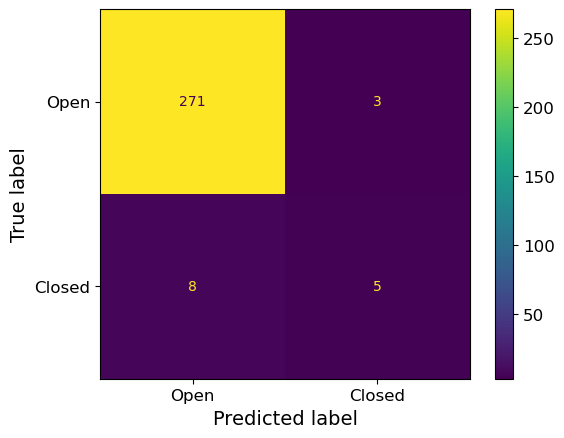

Test set accuracy score for Random Forest Model is  0.9616724738675958
Test set recall score for Random Forest Model is  0.38461538461538464
Test set precision score for Random Forest Model is  0.625
Test set F1 score for Logistic Random Forest is  0.4761904761904762


In [86]:
import matplotlib.pyplot as plt
import numpy
from sklearn import metrics

confusion_matrix3 = metrics.confusion_matrix(y_test, y_pred3)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix3, display_labels = ['Open', 'Closed'])

cm_display.plot()
plt.show()

from sklearn.metrics import accuracy_score
accuracy3 = accuracy_score(y_test, y_pred3)

from sklearn.metrics import recall_score
recall3 = recall_score(y_test, y_pred3)

from sklearn.metrics import precision_score
precision3 = precision_score(y_test, y_pred3)

from sklearn.metrics import f1_score
f13 = f1_score(y_test, y_pred3)

print ('Test set accuracy score for Random Forest Model is ' , accuracy3)
print ('Test set recall score for Random Forest Model is ' , recall3)
print ('Test set precision score for Random Forest Model is ' , precision3)
print ('Test set F1 score for Logistic Random Forest is ' , f13)